In [1268]:
# Marcos Paulo de Oliveira Pereira
#
#
# Data de entrega: 15/07/2024
#
#
# Desafio Técnico Lightouse - Ciência de Dados
#
#

In [1269]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from collections import Counter
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

In [1270]:


df = pd.read_csv('desafio_indicium_imdb.csv')
df['Gross'] = df['Gross'].str.replace(',', '')
df['Gross'] = pd.to_numeric(df['Gross'])


df.isna().sum()
df.shape





(999, 16)

# Análise Descritiva dos Dados

Com foco em desenvolver um filme que seja aceito pela crítica, pelo público e gere retorno financeiro, a _PProductions_ apostou numa análise descritiva dos dados de um banco de dados cinematográfico com os top 1000 filmes de acordo com o [IMDb](https://www.imdb.com). Ao longo desse relatório, vamos percorrer por todos os _insights_ variados que esse banco de dados pôde oferecer.

## Diretores, atores e suas relações com filmes

É possível visualizar quais diretores e atores mais aparecem na lista e como os filmes que eles produziram/aturam se saíram.

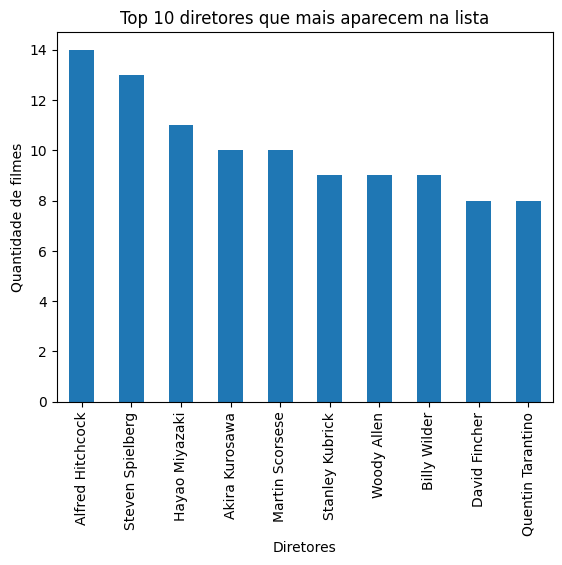

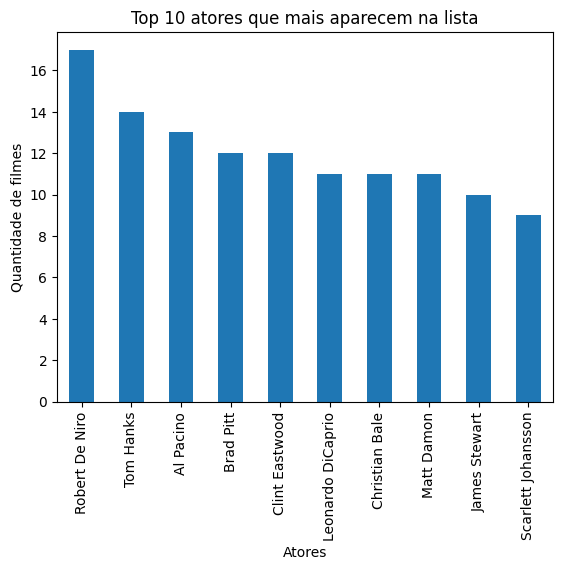

In [1271]:

df['Director'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 diretores que mais aparecem na lista')
plt.ylabel('Quantidade de filmes')
plt.xlabel('Diretores')
plt.show()


df[['Star1', 'Star2', 'Star3', 'Star4']].stack().value_counts().head(10).plot(kind='bar')
plt.title('Top 10 atores que mais aparecem na lista')
plt.ylabel('Quantidade de filmes')
plt.xlabel('Atores')
plt.show()


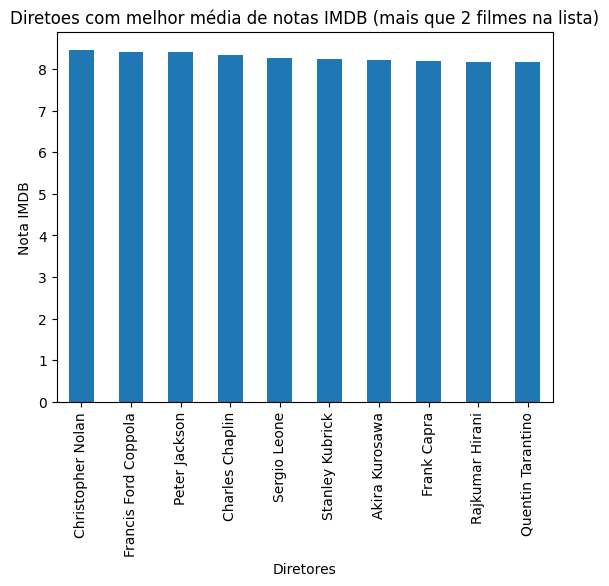

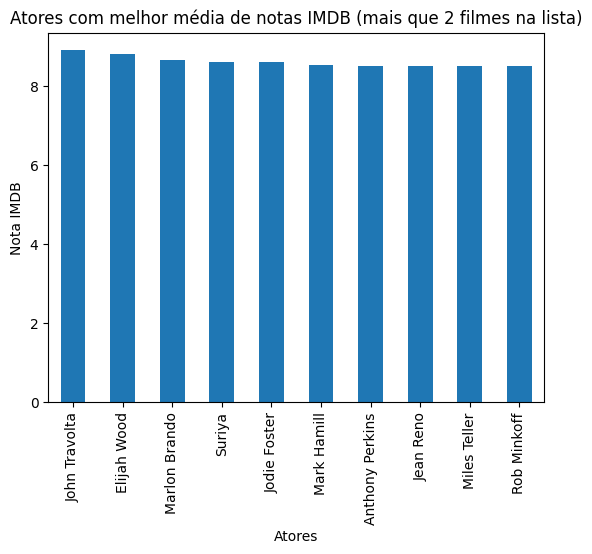

In [1272]:
diretores = df['Director'].value_counts()
atores = df[['Star1', 'Star2', 'Star3', 'Star4']].stack().value_counts()


filtred_diretores = diretores[diretores > 2].index
filtered_diretores = df[df['Director'].isin(filtred_diretores)]

mean_imdb_by_director = filtered_diretores.groupby('Director')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)

mean_imdb_by_director.plot(kind='bar')
plt.title('Diretoes com melhor média de notas IMDB (mais que 2 filmes na lista)' )
plt.ylabel('Nota IMDB')
plt.xlabel('Diretores')
plt.show()


filtred_atores = atores[atores > 2].index
filtered_atores = df[df[['Star1', 'Star2', 'Star3', 'Star4']].isin(filtred_atores).any(axis=1)]

mean_imdb_by_ator = filtered_atores.groupby('Star1')['IMDB_Rating'].mean().sort_values(ascending=False).head(10)    


mean_imdb_by_ator.plot(kind='bar')
plt.title('Atores com melhor média de notas IMDB (mais que 2 filmes na lista)' )
plt.ylabel('Nota IMDB')
plt.xlabel('Atores')
plt.show()





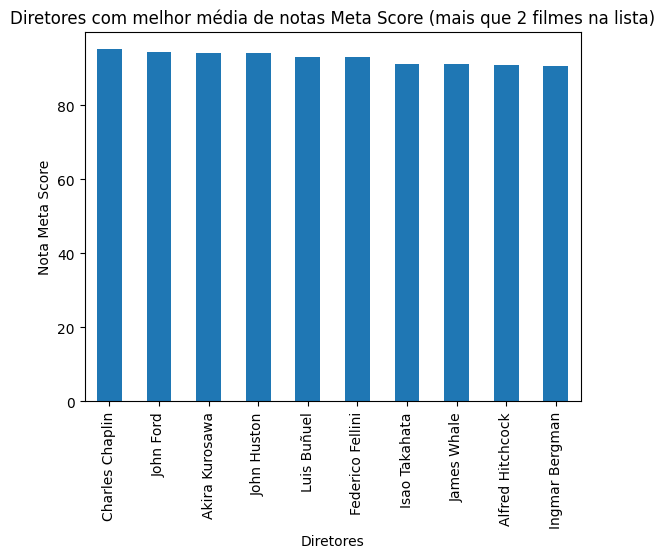

Text(0.5, 0, 'Atores')

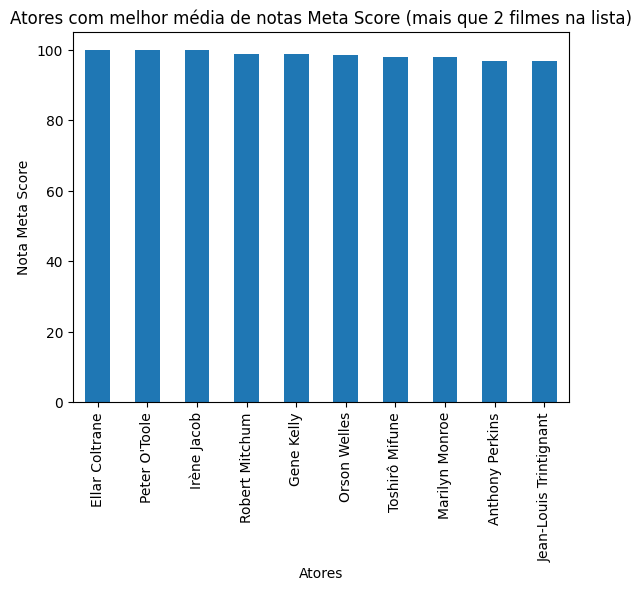

In [1273]:


mean_meta_by_director = filtered_diretores.groupby('Director')['Meta_score'].mean().sort_values(ascending=False).head(10)

mean_meta_by_director.plot(kind='bar')
plt.title('Diretores com melhor média de notas Meta Score (mais que 2 filmes na lista)' )
plt.ylabel('Nota Meta Score')
plt.xlabel('Diretores')
plt.show()

mean_meta_by_ator = filtered_atores.groupby('Star1')['Meta_score'].mean().sort_values(ascending=False).head(10)    

mean_meta_by_ator.plot(kind='bar')
plt.title('Atores com melhor média de notas Meta Score (mais que 2 filmes na lista)' )
plt.ylabel('Nota Meta Score')
plt.xlabel('Atores')




## Análise do Faturamento

Análise dos filmes com maior lucro, como isso está relacionado com o elenco e também com sua recepção pela crítica.


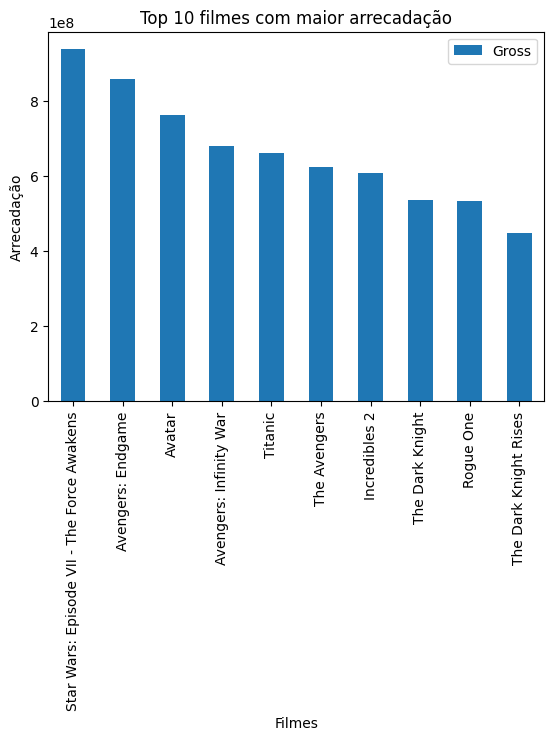

In [1274]:

df[['Series_Title', 'Gross']].sort_values('Gross', ascending=False).head(10).plot(kind='bar', x='Series_Title', y='Gross')
plt.title('Top 10 filmes com maior arrecadação')
plt.ylabel('Arrecadação')
plt.xlabel('Filmes')
plt.show()


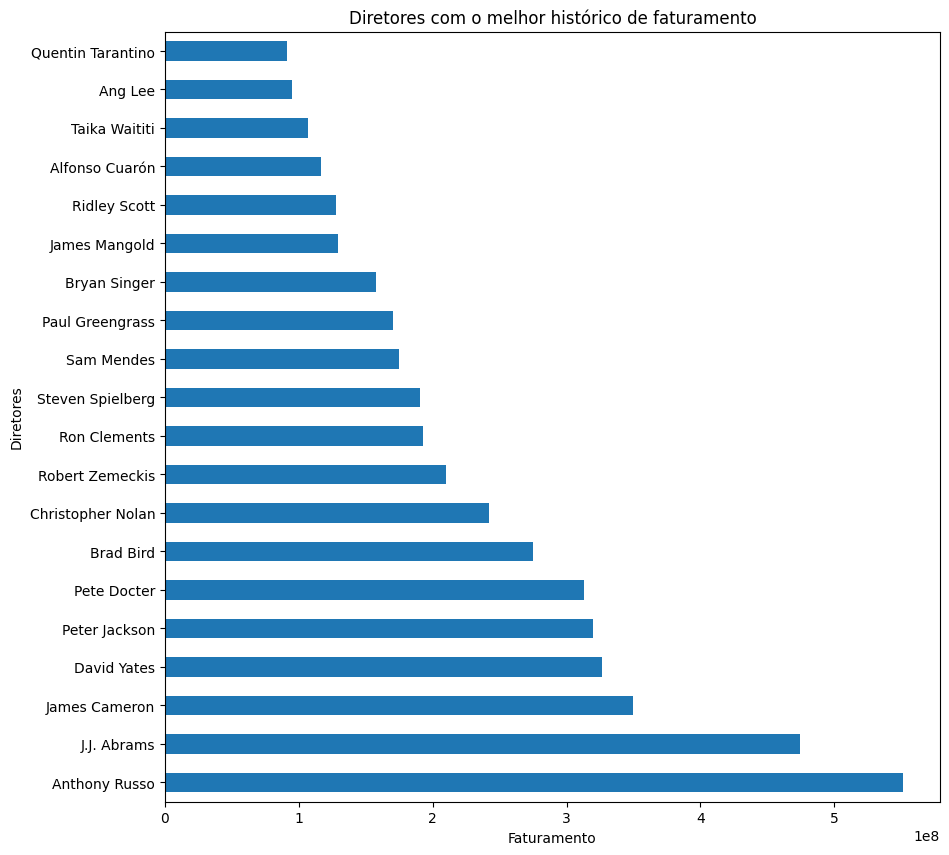

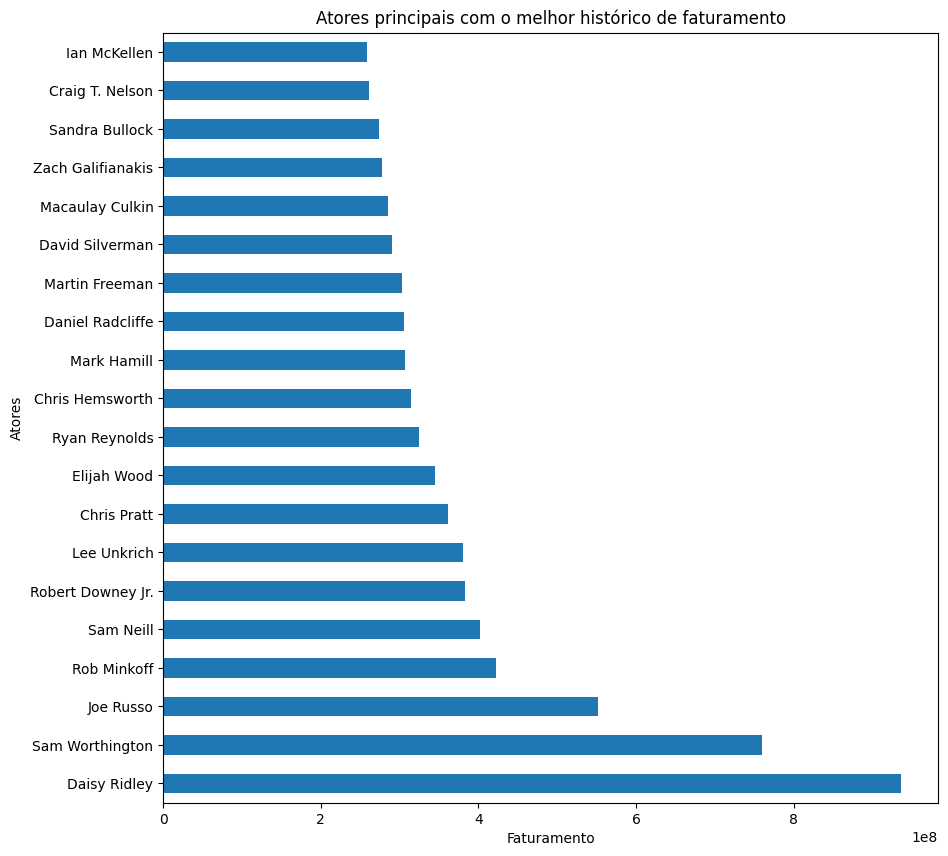

In [1275]:

mean_gross_by_director = filtered_diretores.groupby('Director')['Gross'].mean().sort_values(ascending=False).head(20)
mean_gross_by_director.plot(kind='barh', figsize=(10, 10), title
='Diretores com o melhor histórico de faturamento')

plt.title('Diretores com o melhor histórico de faturamento')
plt.ylabel('Diretores')
plt.xlabel('Faturamento')
plt.show()

mean_gross_by_ator = filtered_atores.groupby('Star1')['Gross'].mean().sort_values(ascending=False).head(20)
mean_gross_by_ator.plot(kind='barh', figsize=(10, 10), title
='Atores com o melhor histórico de faturamento')
plt.title('Atores principais com o melhor histórico de faturamento')
plt.ylabel('Atores')
plt.xlabel('Faturamento')
plt.show()


Sabendo o histórico de faturamento do elenco, ou mesmo de uma franquia, pode ser bem mais fácil de estimar o sucesso que um filme terá nas bilheterias.

## Análise das Sinopses

O banco de dados também contém as sinopses desses filmes. Aproveitando, podemos utilizar uma estratégia para tirar informações delas e contribuir ainda mais para a nossa análise e metas futuras.

In [1276]:
text = list(df['Overview'])
# nltk.download('stopwords')
# nltk.download('wordnet')



lemmatizer = WordNetLemmatizer()

corpus = []
for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('english')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

df['Overview'] = corpus

df.head()


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,organized crime dynasty aging patriarch transf...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,menace known joker wreaks havoc chaos people g...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,early life career vito corleone new york city ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,jury holdout attempt prevent miscarriage justi...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,gandalf aragorn lead world men sauron army dra...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


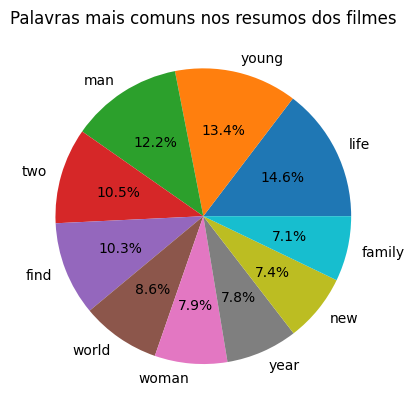

In [1277]:
words = []
for i in range(len(df)):
    words += df['Overview'][i].split()


labels, values = zip(*Counter(words).most_common(10))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Palavras mais comuns nos resumos dos filmes')
plt.show()



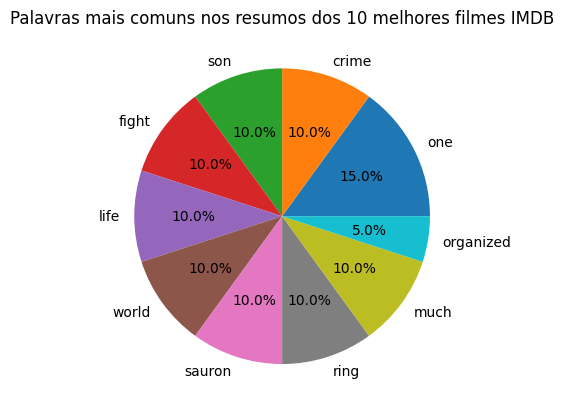

In [1278]:
top_10_imdb = df.sort_values('IMDB_Rating', ascending=False).head(10)
words = []
for i in range(len(top_10_imdb)):
    words += top_10_imdb['Overview'][i].split()

labels, values = zip(*Counter(words).most_common(10))
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Palavras mais comuns nos resumos dos 10 melhores filmes IMDB')
plt.show()

    

As palavras mais utilizadas nessas sinopses ajudam a identificar quais temas são preferidos pelo público e pela crítica (como filmes de ação, crime organizado) e até mesmo quais franquias fazem mais sucesso (Senhor dos Anéis).

## Lucro x Críticas

Saber como o lucro de um filme se relaciona com a sua recepção pela crítica também se torna interessante para o nosso objetivo. Em um gráfico, podemos visualizar a disposição dos filmes com sua nota IMDb e o lucro que eles tiveram (na casa das centenas de milhões).

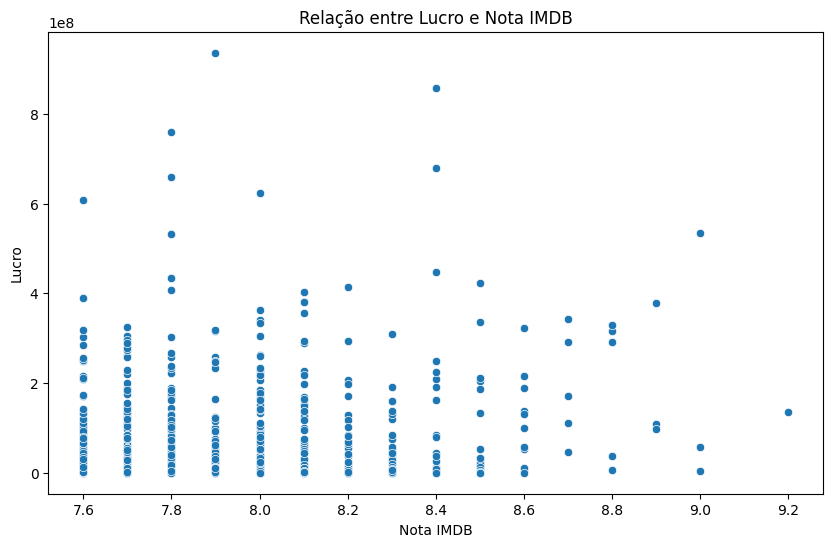

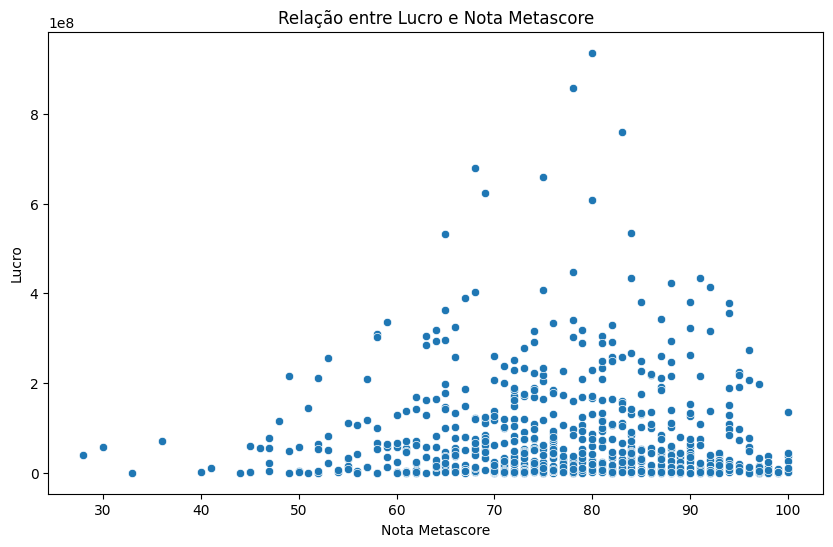

In [1279]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='IMDB_Rating', y='Gross')
plt.title('Relação entre Lucro e Nota IMDB')
plt.xlabel('Nota IMDB')
plt.ylabel('Lucro')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Meta_score', y='Gross')
plt.title('Relação entre Lucro e Nota Metascore')
plt.xlabel('Nota Metascore')
plt.ylabel('Lucro')
plt.show()


## Modelo Preditivo para a Nota IMDb de um filme

Vemos que um filme tem diversas variáveis importantes e até difíceis de analizar, pois uma pode necessariamente não depender da outra. No entanto, mesmo assim, podemos tentar fazer uma modelo que preveja a nota IMDB de um filme de acordo com outras informações recebidas.

Obter um modelo que preveja algo que se porta de uma maneira tão complicada pode ser difícil e requer escolhas acertadas. O problema foi identificado como um problema do tipo de **regressão**, onde a variavél alvo é a nota do IMDb. O modelo utilizado foi o **Gradient Boosting Regressor** e, comparado com outros, obteve um resultado mais aproximado do que queremos medir. Não é um modelo perfeito, principalmente se tratando de algo difícil de prever e com múltiplas variavéis externas, mas é um modelo que permite uma visão próxima e realista do que a variável real seria.

In [1280]:

df['Best_Director'] = df['Director'].apply(lambda x: 1 if x in filtered_diretores else 0)

df['Best_Star1'] = df['Star1'].apply(lambda x: 1 if x in filtered_atores else 0)
df['Best_Star2'] = df['Star2'].apply(lambda x: 1 if x in filtered_atores else 0)
df['Best_Star3'] = df['Star3'].apply(lambda x: 1 if x in filtered_atores else 0)
df['Best_Star4'] = df['Star4'].apply(lambda x: 1 if x in filtered_atores else 0)

most_common_words = [word for word, count in Counter(words).most_common(50)]

for word in most_common_words:
    df[f'word_{word}'] = df['Overview'].apply(lambda x: x.split().count(word))

print(df.head())





   Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  organized crime dynasty aging patriarch transf...       100.0   
1  m

In [1281]:
numerical_features = ['Meta_score', 'Gross', 'Best_Director', 'Best_Star1', 'Best_Star2', 'Best_Star3', 'Best_Star4']
categorical_features = ['Director', 'Star1', 'Star2', 'Star3', 'Star4']
text_features = [f'word_{word}' for word in most_common_words]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', 'passthrough', text_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

X = df.drop(columns=['IMDB_Rating'])
y = df['IMDB_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

new_movie = pd.DataFrame({
    'Series_Title': ['The Shawshank Redemption'],
    'Meta_score': [80.0],
    'Gross': [28341469],
    'Director': ['Frank Darabont'],
    'Star1': ['Tim Robbins'],
    'Star2': ['Morgan Freeman'],
    'Star3': ['Bob Gunton'],
    'Star4': ['William Sadler'],
    'Overview': ['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.']
})

new_movie['Best_Director'] = new_movie['Director'].apply(lambda x: 1 if x in filtered_diretores else 0)
new_movie['Best_Star1'] = new_movie['Star1'].apply(lambda x: 1 if x in filtered_atores else 0)
new_movie['Best_Star2'] = new_movie['Star2'].apply(lambda x: 1 if x in filtered_atores else 0)
new_movie['Best_Star3'] = new_movie['Star3'].apply(lambda x: 1 if x in filtered_atores else 0)
new_movie['Best_Star4'] = new_movie['Star4'].apply(lambda x: 1 if x in filtered_atores else 0)

for word in most_common_words:
    new_movie[f'word_{word}'] = new_movie['Overview'].apply(lambda x: x.split().count(word))

new_movie = new_movie.drop(columns=['Overview'])

new_movie_pred = model.predict(new_movie)
print('Previsão de nota IMDB para o novo filme: %.2f' %  new_movie_pred[0])

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

MAE: 0.20824329006847145
MSE: 0.06473408006462804
RMSE: 0.25442892929977134
R2: 0.01386143341923085
Previsão de nota IMDB para o novo filme: 8.14


## Conclusão

Ao fim desse relatório extraímos informações importantes do banco de dados cinematográfico que vão ajudar no possível desenvolvimento ou caminho de desenvolvimento uma próxima produção da empresa para o cinema. Também criamos um modelo que possibilita estimar a nota IMDb de um filme tendo como base algumas informações sobre ele.
